<a href="https://colab.research.google.com/github/ImITProger/lab1_HelloWorld/blob/main/%D0%A0%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D1%81%D0%BE%D0%B1%D0%B0%D0%BA_%D0%B8_%D0%BA%D0%BE%D1%88%D0%B5%D0%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Распознавание кошек и собак

Для распознавания используется сверточная нейронная сеть.
Основное содержание:
- подключение архива данных
- просмотр содержания дата сета
- создание сверточной сети и ее просмотр
- компиляция сети
- создание генераторов изображений для тренировки и проверки
- обучение нейросети
- оценка качества и вывод графика
- сохранение модели нейросети (структуры и весов), в облако и на локальный компьютер
- загрузка модели нейросети (с новым названием)
- компиляция загруженной нейросети
- распознавание собственных  картинок (загрузка, просмотр, подготовка, классификация на нейросети)


Ноутбук создан с использованием материалов ноутбуков А.Созыкина (УрФУ), а также ноутбуков Виртуальной школы Сбербанка, лето 2020.



# Видео к ноутбуку

А.Созыкин
 - подготовка набора изображений в KERAS https://www.youtube.com/watch?v=_bH2oh75Kdo
 - сохранение и загрузка нейросети https://www.youtube.com/watch?v=ro3s22RyvbA
 - загрузка данных в Colab
https://www.youtube.com/watch?v=Ve5oW1qqbZg
- команды Linux (директории, файлы  и т.п.) https://www.youtube.com/watch?v=1Q_MF-IXzDQ


И другие видео  канала А.Созыкина

https://www.youtube.com/channel/UC5gufuYHPSsJA-jul-iwyXA


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ИМпорт библиотек для работы с файловой системой
# для операций с файлами и каталогами (копирование, перемещение, создание, удаление)
import shutil
import os
from matplotlib import pyplot as plt

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator #функция для загрузки картинок и генератор
from tensorflow.keras.models import Sequential #модели из библиотеке Керас
from tensorflow.keras.layers import Conv2D, MaxPooling2D #слои нейросети
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense


In [ ]:
from tensorflow import keras

Вспомогательные функции

In [ ]:
from os import listdir, sep
from os.path import abspath, basename, isdir
def tree(dir, padding= '  ', print_files=False):
    """
    Эта функция строит дерево поддиректорий и файлов для заданной директории

    Параметры
    ----------
    dir : str
        Path to needed directory
    padding : str
        String that will be placed in print for separating files levels
    print_files : bool
        "Print or not to print" flag
    """
    cmd = "find '%s'" % dir
    files = os.popen(cmd).read().strip().split('\n')
    padding = '|  '
    for file in files:
        level = file.count(os.sep)
        pieces = file.split(os.sep)
        symbol = {0:'', 1:'/'}[isdir(file)]
        if not print_files and symbol != '/':
            continue
        print (padding*level + pieces[-1] + symbol)

In [ ]:
def plot_samples(train_dir, N=4):
  import random
  fig, ax = plt.subplots(2,N,figsize=(5*N,5*2))

  for i,name in enumerate(['buildings','forest']):
    filenames = os.listdir(os.path.join(train_dir,name))

    for j in range(N):
      sample = random.choice(filenames)
      image = load_img(os.path.join(train_dir,name,sample))
      ax[i][j].imshow(image)
      ax[i][j].set_xticks([])
      ax[i][j].set_yticks([])
      ax[i][j].set_title(name)
  plt.grid(False)
  plt.show()

In [ ]:
# Каталог с данными для обучения
train_dir = 'train'
# Каталог с данными для проверки
val_dir = 'val'
# Каталог с данными для тестирования
test_dir = 'test'
# Размеры изображения
img_width, img_height = 150, 150
# Размерность тензора на основе изображения для входных данных в нейронную сеть
# backend Tensorflow, channels_last
input_shape = (img_width, img_height, 3)
# Количество эпох
#было первоначаль
epochs = 30
#epochs = 3
# Размер мини-выборки
batch_size = 16
# Количество изображений для обучения
nb_train_samples = 22500
# Количество изображений для проверки
nb_validation_samples = 2500
# Количество изображений для тестирования
nb_test_samples = 2500



# Набор данных
Набор данных берется по ссылке из интернета. Можно использовать другие наборы - указать иную ссылку, в том числе ссылку на размещение архива на гугл-диске
Набор данных организуется в виде архива, где есть главная директория и поддиректории для обучения и тестирования. В каждой из них - поддиректори  с кошками и собаками.


In [ ]:

!unzip -qq archive.zip

In [ ]:
base_dir = '/content/drive/MyDrive/Colab Files/buildings-vs-forests'


train_dir = os.path.join(base_dir, 'train')

test_dir = os.path.join(base_dir, 'test')

In [ ]:
# Посмотрим, как именно расположены директории с датасетом относительно друг друга
tree(base_dir,print_files=False)

In [ ]:
#Посмотрим на содержание датасета при помощи функции plot_samples
plot_samples(train_dir, N=4)


1) Создаем сверточную нейронную сеть¶

> Блок с отступами


Типовая Архитектура сети

    Слой свертки, размер ядра 3х3, количество карт признаков - 32 шт., функция активации ReLU.
    Слой подвыборки, выбор максимального значения из квадрата 2х2
    Слой свертки, размер ядра 3х3, количество карт признаков - 32 шт., функция активации ReLU.
    Слой подвыборки, выбор максимального значения из квадрата 2х2
    Слой свертки, размер ядра 3х3, количество карт признаков - 64 шт., функция активации ReLU.
    Слой подвыборки, выбор максимального значения из квадрата 2х2
    flatten - Слой преобразования из двумерного в одномерное представление
    Полносвязный слой, 64 нейрона, функция активации ReLU.
    Слой Dropout.
    Выходной слой, 1 нейрон, функция активации sigmoid

Слои с 1 по 6 используются для выделения важных признаков в изображении, а слои с 7 по 10 - для классификации.


2) Далее посмотрим, что из себя представляет эта сеть - вывести информацию о сети с помощью суммари.


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

In [ ]:
# комментария к SUMMARY сети: число параметров - есть число межнейрнонных связей с предыдущим слоем (т.е. весов)
# можно вычислять как число нейронов в выхоной форме предыдущего слоя Х на число нейронов в данном слое + один на байес
# пример: для слоя dence - 18496 Х 64 + 64 = 1183808

3)  нарисовать граф модели с использованием функции Keras
 простой вариант (без вывода форм)
 более сложный вариант - с выводом форм

In [ ]:
keras.utils.plot_model(model, 'info.png', show_shapes=True)

4) Компилируем нейронную сеть
Правильно подобрать оптимизатор, метрику, функцию потерь

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

5)
Создаем генератор изображений

Генератор изображений создается на основе класса ImageDataGenerator. Генератор делит значения всех пикселов изображения на 255.


In [ ]:
datagen = ImageDataGenerator(rescale=1. / 255)

Генератор данных для обучения на основе изображений из каталога


In [ ]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 938 images belonging to 2 classes.


Генератор данных для проверки на основе изображений из каталога


In [ ]:
test_generator = datagen.flow_from_directory(
    #val_dir,
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 560 images belonging to 2 classes.


Генератор данных для тестирования на основе изображений из каталога


6) Обучаем нейросеть с помощью fit
Параметры оубчения заданы выше в виде переменных, исопльзовать их.

In [ ]:
# Каталог с данными для обучения
train_dir = 'train'
# Каталог с данными для проверки
val_dir = 'val'
# Каталог с данными для тестирования
test_dir = 'test'
# Размеры изображения
img_width, img_height = 150, 150
# Размерность тензора на основе изображения для входных данных в нейронную сеть
# backend Tensorflow, channels_last
input_shape = (img_width, img_height, 3)
# Количество эпох
#было первоначаль
epochs = 3
#epochs = 3
# Размер мини-выборки
batch_size = 32
# Количество изображений для обучения
nb_train_samples = 938
# Количество изображений для проверки
nb_validation_samples = 100
# Количество изображений для тестирования
nb_test_samples = 560

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=nb_validation_samples // batch_size)

29/29 [==============================] - ETA: 0s - loss: 0.1403 - accuracy: 0.9520

29/29 [==============================] - 155s 6s/step - loss: 0.1403 - accuracy: 0.9520 - val_loss: 0.1932 - val_accuracy: 0.9179


7) Оцениваем качество работы сети, используем test generator

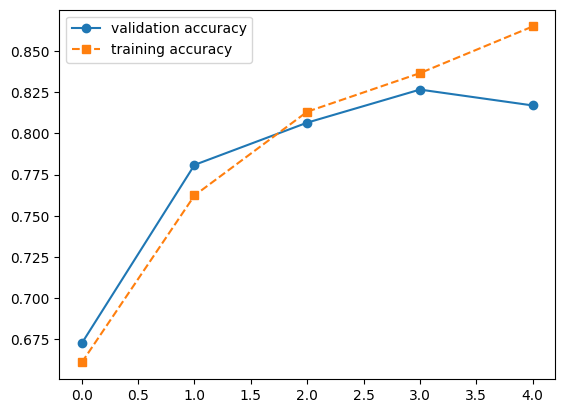

In [ ]:
# Построим изменение точности на трейновой (оранжевая линия) и тестовой (синяя линия)
# выборках
plt.plot(history.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(history.history['accuracy'], '--s', label='training accuracy')
plt.legend();

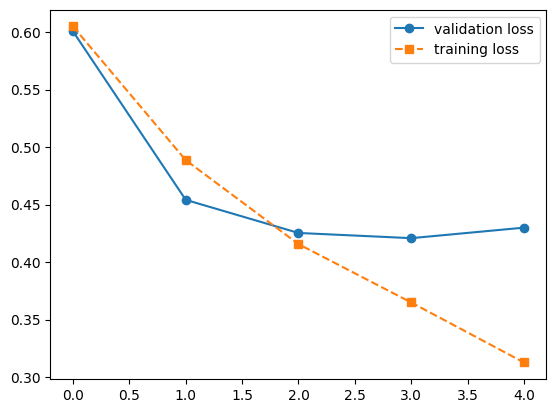

In [ ]:
# Построим изменение потерь на трейновой (оранжевая линия) и тестовой (синяя линия)
# выборках
plt.plot(history.history['val_loss'], '-o', label='validation loss')
plt.plot(history.history['loss'], '--s', label='training loss')
plt.legend();

In [ ]:
# Взглянем на итоговые результаты классификации на тестовой выборке
# (функция ошибки, точность)
model.evaluate(test_generator)

157/157 [==============================] - 4s 25ms/step - loss: 0.4295 - accuracy: 0.8172


[0.4295336902141571, 0.8172000050544739]

8) Далее сохраним модель сети



Подробнее про сохранение и считывание модели - см. здесь https://blog.stroganov.pro/%D1%81%D0%BE%D1%85%D1%80%D0%B0%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5-%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8-%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D0%BE%D0%B9-%D1%81%D0%B5%D1%82%D0%B8/

Там же смотри подробнее про сохранение/считывание весов


Материалы Colab по внешним данным ( сохранение, считывание в память колаба): https://colab.research.google.com/notebooks/io.ipynb

Внимание! Ниже показано сохранение с устаревшим способом. Нужно применит ьболее современный способ сохранения модели с помощью save в формате .h5

In [ ]:
print("Сохраняем сеть")
# Сохраняем сеть для последующего использования
# Генерируем описание модели в формате json
model_json = model.to_json()
json_file = open("CAT_and_DOG.json", "w")
# Записываем архитектуру сети в файл
json_file.write(model_json)
json_file.close()
# Записываем данные о весах в файл
model.save_weights("CAT_and_DOG.h5")
print("Сохранение сети завершено")

In [ ]:
#вызов метода для работы с файлами (загрузки)
from google.colab import files


In [ ]:
#собственно сохранение
files.download("CAT_and_DOG.json")

In [ ]:
#сохраняем веса сети
files.download("CAT_and_DOG.h5")

9) Загружаем сохраненную в формате .h5 сеть


In [ ]:
from keras.models import model_from_json

In [ ]:
#загрузка данныйх нейросети из файла
#!wget Здесь нужно прописать адрес созраненных данных на внешнем сайте https://.....

In [ ]:
#!wget http://

In [ ]:
# посмотрим содержимое директории в колабе с помощью команды:
!ls

In [ ]:
#!head Указать имя файла для просмотра просмотр сохраненной нейросети, нужно вписать название файла по факту
!head CAT_and_DOG.json


In [ ]:
#!head CAT_and_DOG.h5

ниже показан пример - загрузка сохраненной  модели и вестов  в json файле

In [ ]:
print("Загружаю сеть из файлов")
# Загружаем данные об архитектуре сети
json_file = open("CAT_and_DOG.json", "r")
loaded_model_json = json_file.read()
json_file.close()
# Создаем модель
loaded_model = model_from_json(loaded_model_json)
# Загружаем сохраненные веса в модель
loaded_model.load_weights("CAT_and_DOG.h5")
print("Загрузка сети завершена")

Далее мы можем проводить с переменной loaded_model все процедуры, обучать, прогнозировать, но сначала ее нужно скмопилировать, т.е.  вызвать ее метод compile.

In [ ]:
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Взглянем на итоговые результаты классификации этой загруженной модели на тестовой выборке
# (функция ошибки, точность). Она по идее совпадает со значениями ранее оубченной и сохраненной сети
loaded_model.evaluate(test_generator)

10) Используем модель для распознавания своего изображения
Сначала загружаем свое изображение.



Дополнительно см. материалы ноутбуков А. Созыкина
 https://colab.research.google.com/drive/1K3Pn8aXM06hUfhn241y8UIGQ_xcHKF8n#scrollTo=44DYnv7NJ9M9


In [ ]:
from IPython.display import Image
from tensorflow.keras.preprocessing import image

про загрузку изображений см здесь:
https://www.youtube.com/watch?v=Ve5oW1qqbZg


In [ ]:
#если выше не было этого вызова вызов метода для работы с файлами (загрузки)
from google.colab import files

In [ ]:
f = files.upload()


In [ ]:
#смотрим, что есть в облачном хранилище, есть ли там наша картинка
!ls


In [ ]:
# если хочется посмотреть текущйи каталог]
!pwd



In [ ]:
#Покажем файл в облачном хранилище
Image ('/content/People_test/1.jpg')

In [ ]:
img_path = '/content/People_test/3.jpg'

In [ ]:
def catOrDog(num):
  if num == 1:
    return 'Dog'
  else:
    return 'Cat'

In [ ]:
import os
import numpy as np
from pathlib import Path

directory = '/content/People_test'
for entry in Path(directory).iterdir():
  print(entry)
  # Преобразуем картинку в вектор , массив numpy
  Image(entry, width=150, height=150)
  #устанавливаем целевой размер, как и ранее при обучении - 150 на 150
  img = image.load_img(entry, target_size=(150, 150), grayscale=False)
  # Преобразуем изображением в массив numpy и нормализуем
  x = image.img_to_array(img)
  x = 255 - x
  x /= 255
  x = np.expand_dims(x, axis=0)
  prediction = model.predict(x)
  print(catOrDog(round(prediction[0][0])))

/content/People_test/6.jpg
1/1 [==============================] - 0s 66ms/step
Dog
/content/People_test/3.jpg
1/1 [==============================] - 0s 26ms/step
Dog
/content/People_test/1.jpg
1/1 [==============================] - 0s 31ms/step
Cat
/content/People_test/4.jpg
1/1 [==============================] - 0s 37ms/step
Cat
/content/People_test/2.jpg
1/1 [==============================] - 0s 53ms/step
Dog
/content/People_test/8.jpg
1/1 [==============================] - 0s 20ms/step
Dog
/content/People_test/7.jpg
1/1 [==============================] - 0s 18ms/step
Dog
/content/People_test/5.jpg
1/1 [==============================] - 0s 18ms/step
Dog


11) Выполнить распознавание изображения с помощью модели загруженной ранее с компьютера нейросети


In [ ]:
# prediction =
print (prediction)


In [ ]:
# по итогам арспознавания вывести на печать наименование распозгнанного класса (кошка или собака)


**Дополнительное Задание:**
Д1) Получить доступ к внутренним слоям обученной модели
Д2) Вывести на экран изображения карт признаков для выбранных внутренних слоев

Проба: доступ к промежуточным слоям оубченной модели.
Нужно сделать отдельные модели для каждого из интересующих слоев. (со своим аутпутом)
- Сделать предсказание каждой из этих моделей - в переменную вида prediction.
- Посмотреть форму тензора на выходе этих моделей (вывести на экран).
- Далее  этот тензор (массив чисел) преобразовать в изображение и вывести на экран (использовать вспомогательные библиотеки Pil, openCV  и др.)

In [ ]:
#Попробуем получить доступ к внутренним слоям модели
from keras.models import Model
# Имя слоя берется из Summury нейросети
model2= Model(model.input,model.get_layer('conv2d_2').output)
#model2= Model(model.input,model.layers[1].output)

In [ ]:
preds=model2.predict(x)

In [ ]:
# разбираемся в форме результата
np.shape(preds)

In [ ]:
# смотрим отдельные элементы , например
preds_a=preds[0,:,:,:]

In [ ]:
np.shape(preds_a)

In [ ]:
# можно создать еще одну модель, которая будет иметь доступ к другому внутреннему слою
model3= Model(model.input,model.get_layer('max_pooling2d_2').output)

In [ ]:
preds3=model3.predict(x)

In [ ]:
np.shape(preds3)

In [ ]:
preds3_a=preds3[0,:,:]

In [ ]:
np.shape(preds3_a)

In [ ]:
prob_img=preds3_a[:,:]


In [ ]:
np.shape(prob_img[:,:,:1])

In [ ]:
# вывод изображения из массива - можно использовать преобразование image.fromarray

Выше мы определили prediction. Если это просто картинка-массив Высота х Ширина, то работает - выводится одно изображение размером этой Высоты и Ширины. Если же это тензор - много таких массивов, то они все накладываются в плоское изображение такой же Высоты и ширины

Д3) попробовать, как будет вглядеть то же самое изображение, но после функции активации. То есть в качестве аутпута модели ставим слой после активации 'activation'

In [ ]:
model4= Model(model.input,model.get_layer('activation').output)
preds4=model4.predict(x)
preds4_a=preds4[0,:,:]
np.shape(preds4_a)


In [ ]:
# с помощью библиотек (PIL  и т.п.) попробовать изменять размеры изображения